In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

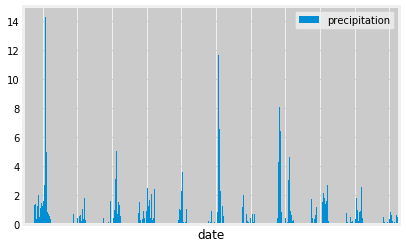

In [85]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

year_ago = dt.datetime.strptime(latest_date[0], "%Y-%m-%d").date() - dt.timedelta(days=365)

query_df = pd.DataFrame(session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_ago).all())

query_df.set_index("date", inplace=True)

query_df = query_df.rename(columns={"prcp":"precipitation"})

query_df = query_df.groupby("date").sum()

# Sort the dataframe by date

sorted_query_df = query_df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data

sorted_query_df.plot.bar(label='date', grid=True)
plt.tick_params(axis='x',which='both',bottom=False,labelbottom=False)
plt.savefig('Images/precipitation.png')
plt.show()

In [86]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_query_df.describe()

,precipitation
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


In [136]:
# Design a query to show how many stations are available in this dataset?

num_stations = session.query(Measurement.station).\
    group_by(Measurement.station).count()
print("The number of stations is: " + str(num_stations))


The number of stations is: 9


In [207]:
dates = session.query(Measurement.station,func.count(Measurement.date)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.date).desc()).all()

print(dates)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [171]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

busiest_station = dates[0][0]

sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
results = session.query(*sel).\
    filter(Measurement.station == busiest_station).all()
results


[('USC00519281', 54.0, 85.0, 71.66378066378067)]

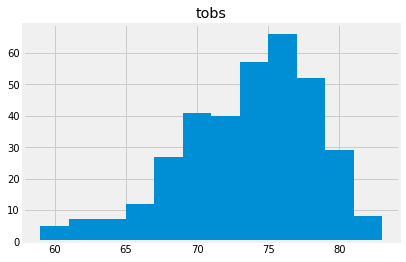

In [186]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

results_df = pd.DataFrame(session.query(Measurement.tobs).\
    filter(Measurement.date > year_ago).\
    filter(Measurement.station == busiest_station).all()
)
results_df.hist(bins=12)
plt.savefig('Images/station-histogram.png')
plt.show()

In [187]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [193]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

start_date = '2017-06-01'
end_date = '2017-06-10'
ptps = calc_temps(start_date, end_date)
print(ptps)

[(72.0, 77.546875, 81.0)]


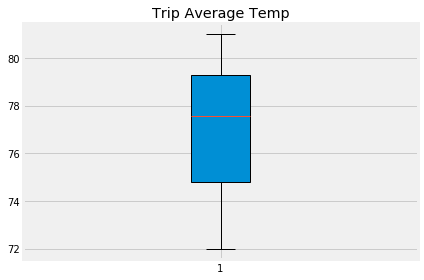

In [196]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots()

x = range(len(ptps))
ax.boxplot(ptps, patch_artist=True)
ax.set_title('Trip Average Temp')
fig.tight_layout()
plt.show()


In [205]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

#       func.min(Measurement.tobs), 
# Measurement.date, Measurement.prcp, 

sel = [Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation]
same_station = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Measurement.station).\
    order_by (func.sum(Measurement.prcp).desc()).all()
print(same_station)


[('USC00519281', 0.99, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), ('USC00514830', 0.92, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), ('USC00516128', 0.85, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00513117', 0.73, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), ('USC00519523', 0.28, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5), ('USC00519397', 0.06, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), ('USC00517948', None, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [23]:
# Plot the daily normals as an area plot with `stacked=False`
